In [1]:
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import mixed_precision
import numpy as np
import matplotlib.pyplot as plt
from conditional_GAN import WGAN, Generator, Discriminator

2023-07-07 01:36:38.071141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 01:36:38.169024: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# mirrored_strategy = tf.distribute.MirroredStrategy()

# mixed_precision.set_global_policy('mixed_float16')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
path = "cmnist/fgbg_cmnist_cpr0.5-0.5/"
mnist_train = tf.convert_to_tensor(np.load(path + "colored_mnist_init_train.npy"))
mnist_test = tf.convert_to_tensor(np.load(path + "colored_mnist_init_test.npy"))
mnist_train_target = tf.convert_to_tensor(
    np.load(path + "colored_mnist_target_train.npy")
)
mnist_test_target = tf.convert_to_tensor(
    np.load(path + "colored_mnist_target_test.npy")
)

mnist_train = tf.transpose(mnist_train, [0, 2, 3, 1])
mnist_test = tf.transpose(mnist_test, [0, 2, 3, 1])

print(mnist_train.shape, mnist_test.shape)
print(mnist_train_target.shape, mnist_test_target.shape)

train_data = tf.data.Dataset.from_tensor_slices((mnist_train, mnist_train_target))

batch_size = 128
train_data = train_data.shuffle(10000).batch(batch_size)

2023-07-07 01:36:40.211737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 01:36:40.669787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37666 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0
2023-07-07 01:36:40.671510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37274 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:d8:00.0, compute capability: 8.0


(60000, 28, 28, 3) (10000, 28, 28, 3)
(60000, 7) (10000, 7)


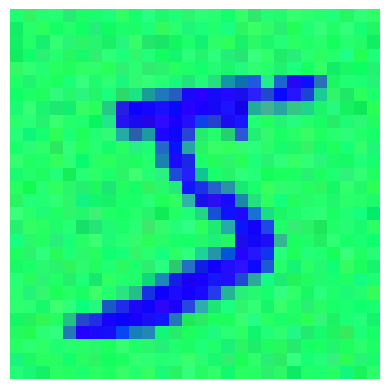

In [4]:
plt.figure(1)
plt.imshow(mnist_train[0, :, :, :])
plt.axis("off")
plt.show()

In [6]:
discriminator = Discriminator(
    shape=mnist_train.shape[1:], label_dim=mnist_train_target.shape[1]
)
discriminator.model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        4160      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524544    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 512)       

In [7]:
latent_dim = 128

generator = Generator(latent_dim=latent_dim, label_dim=mnist_train_target.shape[1])
generator.model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              139264    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024)              0         
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 4, 4, 256)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)         59

In [8]:
# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img: tf.Tensor, fake_img: tf.Tensor):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img: tf.Tensor):
    return -tf.reduce_mean(fake_img)

In [9]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

wgan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim,
    discriminator_extra_steps=5,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

epochs = 50
wgan.fit(train_data, epochs=epochs)

Epoch 1/50


2023-07-07 01:37:24.673314: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-07 01:37:24.705000: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800


469/469 [==============================] - 38s 64ms/step - d_loss: -6.6589 - g_loss: -4.0649
Epoch 2/50
469/469 [==============================] - 29s 63ms/step - d_loss: -5.1426 - g_loss: -2.5944
Epoch 3/50
469/469 [==============================] - 29s 62ms/step - d_loss: -4.6811 - g_loss: -2.6425
Epoch 4/50
469/469 [==============================] - 28s 60ms/step - d_loss: -4.3348 - g_loss: -2.7211
Epoch 5/50
469/469 [==============================] - 29s 62ms/step - d_loss: -4.0989 - g_loss: -1.1675
Epoch 6/50
469/469 [==============================] - 29s 61ms/step - d_loss: -3.7973 - g_loss: -2.6369
Epoch 7/50
469/469 [==============================] - 29s 62ms/step - d_loss: -3.6680 - g_loss: -1.8281
Epoch 8/50
469/469 [==============================] - 28s 61ms/step - d_loss: -3.4526 - g_loss: -0.3315
Epoch 9/50
469/469 [==============================] - 29s 62ms/step - d_loss: -3.1850 - g_loss: -2.1599
Epoch 10/50
469/469 [==============================] - 29s 61ms/step - d_lo

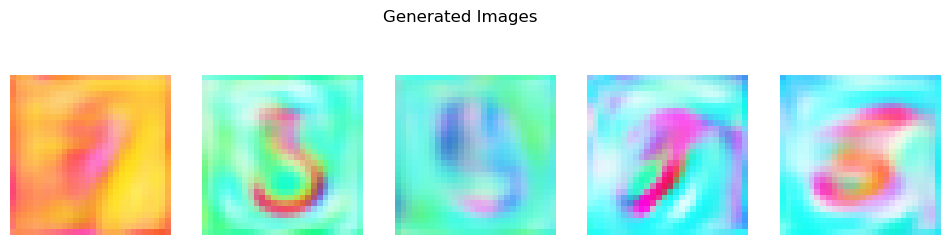

In [52]:
num_images = 5
random_noise = tf.random.normal(shape=(num_images, latent_dim))
generated_images = wgan.generator(
    random_noise, mnist_test_target[:num_images], training=False
)

plt.figure(figsize=(12, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i, :, :, :])
    plt.axis("off")

plt.suptitle("Generated Images")
plt.show()